In [1]:
# Import required libraries into the project
import deeplake
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
# load GTZAN dataset
ds = deeplake.load("hub://activeloop/gtzan-genre")

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



\

hub://activeloop/gtzan-genre loaded successfully.



In [3]:
# Method for converting audio files into melspectrograms for better classification
def audio_to_melspectrogram(audio_tensor, sr=22050, n_fft=4096, hop_length=1024, n_mels=256):
    # convert tensor to numpy array
    audio_array = audio_tensor.numpy()
    
    # compute mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert to decibels
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram_db

# Method for coverting audio files into mfcc spectrograms
def audio_to_mfcc(audio_tensor, sr=22050, n_fft=4096, hop_length=1024, n_mfcc=60):
    # convert tensor to numpy array
    audio_array = audio_tensor.numpy()
    
    # compute mel spectrogram
    mfcc = librosa.feature.mfcc(y=audio_array.squeeze(), sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    
    return mfcc

In [4]:
def genre_tensor_to_string(genre):
    # map number to genre name
    number_genre_map = {0:"Pop", 1:"Metal", 2:"Classical", 3:"Rock", 4:"Blues", 5:"Jazz",
                        6:"Hip-hop", 7:"Reggae", 8:"Disco", 9:"Country"}
    
    genre_number = genre.numpy()[0]

    return number_genre_map[genre_number]

In [5]:
# Plot the spectrogram for a specific audio file
def plot_spectrogram(spectrogram, genre):
    # display spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram of {genre_tensor_to_string(genre).lower()} song')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

In [6]:
# create list of spectrograms
spectrograms = []

for i, audio_tensor in enumerate(ds["audio"]):
    spectrograms.append(audio_to_melspectrogram(audio_tensor))

In [7]:
# create list of mfcc values for each song
mfccs = []

for i, audio_tensor in enumerate(ds["audio"]):
    mfccs.append(audio_to_mfcc(audio_tensor))

In [8]:
# create list of tuple containing spectrogram and genre
spectrograms_with_genre = []
genre_labels = []

for i, spectrogram in enumerate(spectrograms):
    spectrograms_with_genre.append((spectrogram, ds["genre"][i]))
    genre_labels.append(ds["genre"][i].numpy())

In [9]:
def pad_numpy_columns(numpy_arrs, target_number=2000):
    # Pad each spectrogram to have the target number of columns
    padded_numpy_arrs = []
    for arr in numpy_arrs:
        num_columns_to_pad = target_number - arr.shape[1]
        if num_columns_to_pad > 0:
            # Pad with zeros to the right (after the spectrogram)
            padded_arr = np.pad(arr, ((0, 0), (0, num_columns_to_pad)), mode='constant')
        else:
            # No padding needed
            padded_arr = arr
        padded_numpy_arrs.append(padded_arr)
    
    return padded_numpy_arrs

In [10]:
# Pad the spectrograms to have only 1320 columns
padded_spectrograms = pad_numpy_columns(spectrograms, target_number=1320)
padded_mfccs = pad_numpy_columns(mfccs, target_number=1320)

In [11]:
padded_spectrograms[201].shape

(256, 1320)

In [24]:
# Prepare the spectrograms to run through a KNN algorithm (Abandoned approach)
spectrograms_flat = [spec.flatten() for spec in padded_spectrograms]
x1_train, x1_test, y1_train, y1_test = train_test_split(spectrograms_flat, genre_labels, test_size=0.2, random_state=51)
knn_model_spectrograms = KNeighborsClassifier(n_neighbors=5)
knn_model_spectrograms.fit(x1_train, y1_train)

c:\Users\lwolf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [25]:
# Prepare the mfcc to run through a KNN algorithm (Abandoned approach)
mfccs_flat = [mfcc.flatten() for mfcc in padded_mfccs]
x2_train, x2_test, y2_train, y2_test = train_test_split(mfccs_flat, genre_labels, test_size=0.2, random_state=51)
knn_model_mfccs = KNeighborsClassifier(n_neighbors=5)
knn_model_mfccs.fit(x2_train, y2_train)

c:\Users\lwolf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [26]:
# Evaluate the data from running the KNN algorithm and print the accuracy (For mel spectrograms)
y1_pred = knn_model_spectrograms.predict(x1_test)

accuracy = accuracy_score(y1_test, y1_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.38


In [27]:
# Evaluate the data from running the KNN algorithm and print the accuracy (For mfcc)
y2_pred = knn_model_mfccs.predict(x2_test)

accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.33


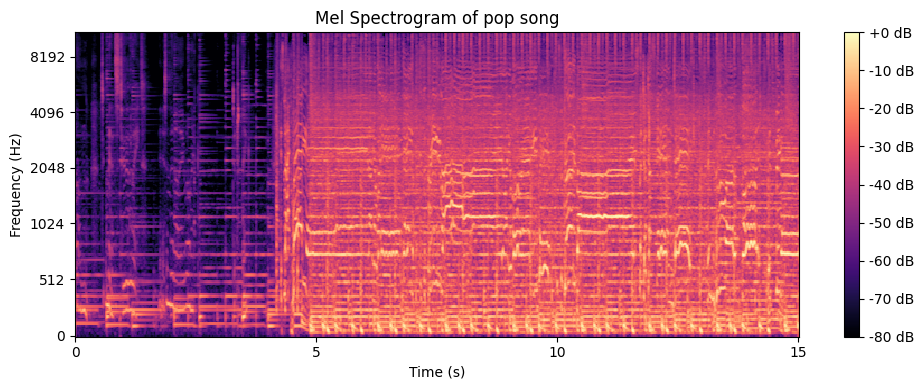

In [16]:
# example of plotted spectrogram

plot_spectrogram(spectrograms_with_genre[0][0], spectrograms_with_genre[0][1])

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from keras.utils import to_categorical

In [18]:
padded_spectrograms[0].shape

(256, 1320)

In [19]:
# Split code into training and testing sets
x1_train, x1_test, y1_train, y1_test = train_test_split(padded_spectrograms, genre_labels, test_size=0.2, random_state=51)

In [20]:
y1_train_encoded = to_categorical(y1_train, num_classes=10)  # Assuming you have 10 classes
y1_test_encoded = to_categorical(y1_test, num_classes=10)

In [21]:
# Convert training and testing sets into numpy arrays
x1_train_array = np.array(x1_train)
x1_test_array = np.array(x1_test)
y1_train_encoded_array = np.array(y1_train_encoded)
y1_test_encoded_array = np.array(y1_test_encoded)

In [22]:
x1_train_array.shape

(800, 256, 1320)

In [23]:
# Define the CNN model architecture
# Define the CNN model architecture
model = Sequential()
model.add(Reshape((256, 1320, 1), input_shape=(256, 1320)))  # Add a channel dimension
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Adjust num_classes according to your task

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x1_train_array, y1_train_encoded_array, batch_size=32, epochs=10, validation_data=(x1_test_array, y1_test_encoded_array))

c:\Users\lwolf\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.0896 - loss: 4117.9214 - val_accuracy: 0.1000 - val_loss: 362.2855
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.1816 - loss: 177.3975 - val_accuracy: 0.2250 - val_loss: 27.6899
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.4267 - loss: 11.0681 - val_accuracy: 0.4150 - val_loss: 4.1224
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9395 - loss: 0.2086 - val_accuracy: 0.4650 - val_loss: 3.2699
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.9952 - loss: 0.0245 - val_accuracy: 0.4700 - val_loss: 3.3479
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.9992 - loss: 0.0089 - val_accuracy: 0.4850 - val_loss: 3.3713
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9994 - loss: 0.0043 - val_accuracy: 0.4850 - val_loss: 3.3815
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 0.4900